# Hello everyone!

This is our project for the Natural Language Processing subject presented by our group: PARS-ing

Team members:

*   Pinar Erbil
*   Angela Remolina
*   Rio Ishibashi
*   Sergio Pardo



# 1. Preliminary analysis:
For this section we will analyze what the dataset contains and how is it structured. We'll also use some cool graphic plots to visualise the content.

The lines and conversation files that are conected with an ID of the line in the conversation.

> According to the dataset documentation these file contains
* 220,579 conversational exchanges between 10,292 pairs of movie characters
* involves 9,035 characters from 617 movies
* in total 304,713 utterances

Also on the titles file we can see

> Movie metadata included:
* genres
* release year
* IMDB rating
* number of IMDB votes
* IMDB rating

And this information for the characters file

> Character metadata included:
* gender (for 3,774 characters)
* position on movie credits (3,321 characters)


## 1.1 Data preprocessing (R)
**First, we started by loading the dataset and creating dataframes. We created dataframes with the lines and another with the dialogues.**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

import os

path = 'Colab Notebooks/NLP/Project'

os.chdir(f'/content/drive/MyDrive/{path}')
os.getcwd()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/Colab Notebooks/NLP/Project'

In [5]:
### Downloads ###
!pip install joblib
!pip install keras==3.3.3
!pip install tensorflow==2.16.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 8.0 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 79.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 79.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 83.4 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling

In [6]:
### imports ###
import tensorflow as tf
import keras
import re
import pandas as pd
import ast
import numpy as np
import joblib
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Choose whether to use the whole dataset or just a small part of it

In [7]:
dataset = 'cornell-movie-dialogs-small'

These are the different files found in the dataset, let's see what's inside of them

In [8]:
with open(f'{dataset}/movie_lines.txt') as f:
    lines = f.readlines()

with open(f'{dataset}/movie_conversations.txt') as f:
    conversations = f.readlines()

with open(f'{dataset}/movie_titles_metadata.txt', encoding='latin-1') as f:
    titles = f.readlines()

with open(f'{dataset}/movie_characters_metadata.txt', encoding='latin-1') as f:
    characters = f.readlines()

For easier visualization, we'll load the Loading them into a pandas dataframe, starting with the lines.


As we saw before, each column of the dataset is splitted by the string `+++$+++` then we'll set that as a parameter for the split function. Also we'll delete the last `\n` symbol from the line

In [9]:
## Clean contractions
def clean_text(text): #adapted from https://github.com/REDFOX1899/Chatbot/blob/master/Chatbot.py
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", text)

    # from some common specific mistakes found in this dataset
    text = re.sub(r"youíre", "you are", text)
    text = re.sub(r"óó", "", text)

    return text

In [10]:
# create dataframe with lines
df_lines = pd.DataFrame({'line_text': lines})

# split into columns
df_lines = df_lines['line_text'].str.split(r' \+\+\+\$\+\+\+ ', expand=True)
df_lines.columns = ['line_ID', 'speaker_ID', 'movie','speaker','text']

# delete new line character and other blank character
df_lines = df_lines.applymap(lambda x: x.strip() if isinstance(x, str) else x)
df_lines['text'] = df_lines['text'].str.strip('\n')

# Add column clean text
df_lines['clean_text'] = df_lines['text'].apply(lambda x: clean_text(x))

#might be needed?
# # add column speaker + text
# df_lines['line'] = df_lines['speaker'] + ": " + df_lines['clean_text']

df_lines.head(5)

,line_ID,speaker_ID,movie,speaker,text,clean_text
0,L1045,u0,m0,BIANCA,They do not!,they do not
1,L1044,u2,m0,CAMERON,They do to!,they do to
2,L985,u0,m0,BIANCA,I hope so.,i hope so
3,L984,u2,m0,CAMERON,She okay?,she okay
4,L925,u0,m0,BIANCA,Let's go.,let's go


Now let's do the same thing with all the other txt files

In [11]:
# create dataframe with conversations
df_conv = pd.DataFrame({'conv': conversations})

# split into columns
df_conv = df_conv['conv'].str.split(r' \+\+\+\$\+\+\+ ', expand=True)
df_conv.columns = ['speaker1_ID', 'speaker2_ID', 'movie_ID','lines_list']

# delete new line character
df_conv['lines_list'] = df_conv['lines_list'].str.strip('\n')

# set lines_list to list type
df_conv['lines_list'] = df_conv['lines_list'].apply(ast.literal_eval)

df_conv.head(5)

,speaker1_ID,speaker2_ID,movie_ID,lines_list
0,u0,u2,m0,"[L194, L195, L196, L197]"
1,u0,u2,m0,"[L198, L199]"
2,u0,u2,m0,"[L200, L201, L202, L203]"
3,u0,u2,m0,"[L204, L205, L206]"
4,u0,u2,m0,"[L207, L208]"


In [12]:
# create dataframe with titles
df_title = pd.DataFrame({'title': titles})

# split into columns
df_title = df_title['title'].str.split(r' \+\+\+\$\+\+\+ ', expand=True)
df_title.columns = ['movie_ID','title','year','IMBD_rating','IMBD_votes','genres']

# cast types to what they are
df_title['IMBD_rating'] = df_title['IMBD_rating'].astype(float)
df_title['IMBD_votes'] = df_title['IMBD_votes'].astype(int)
# Clean 'year' column using regex (for cases like ' 1989/I ')
df_title['year'] = df_title['year'].apply(lambda x: re.sub(r'\D', '', x))  # \D means "no digit"
df_title['year'] = df_title['year'].astype(int)

# delete new line character
df_title['genres'] = df_title['genres'].str.strip('\n')

# set genres_list to list type
df_title['genres'] = df_title['genres'].apply(ast.literal_eval)
df_title.head(5)

,movie_ID,title,year,IMBD_rating,IMBD_votes,genres
0,m0,10 things i hate about you,1999,6.9,62847,"[comedy, romance]"
1,m1,1492: conquest of paradise,1992,6.2,10421,"[adventure, biography, drama, history]"
2,m2,15 minutes,2001,6.1,25854,"[action, crime, drama, thriller]"
3,m3,2001: a space odyssey,1968,8.4,163227,"[adventure, mystery, sci-fi]"
4,m4,48 hrs.,1982,6.9,22289,"[action, comedy, crime, drama, thriller]"


In [13]:
# create dataframe with conversations
df_chars = pd.DataFrame({'characters': characters})

# split into columns
df_chars = df_chars['characters'].str.split(r' \+\+\+\$\+\+\+ ', expand=True)
df_chars.columns = ['character_ID','name','movie_ID','movie_title','gender','credits_pos']

# delete new line character
df_chars['credits_pos'] = df_chars['credits_pos'].str.strip('\n')

# cast credits_pos to int (-1 if unknown)
df_chars.loc[df_chars['credits_pos'] == '?', 'credits_pos'] = -1
df_chars['credits_pos'] = df_chars['credits_pos'].astype(int)  # max(df_chars['credits_pos']) = 1000

df_chars.head(5)

,character_ID,name,movie_ID,movie_title,gender,credits_pos
0,u0,BIANCA,m0,10 things i hate about you,f,4
1,u1,BRUCE,m0,10 things i hate about you,?,-1
2,u2,CAMERON,m0,10 things i hate about you,m,3
3,u3,CHASTITY,m0,10 things i hate about you,?,-1
4,u4,JOEY,m0,10 things i hate about you,m,6


For easier handle of the conversations and lines we'll join them together in one dataframe

In [14]:
# Create a guide index
df_conv['index'] = df_conv.index
# Expand list into all sub item lines
expanded_lines = df_conv.explode('lines_list')
# Reset index of expanded df
expanded_lines.reset_index(drop=True, inplace=True)
# merge the line with line ids
merged_df = pd.merge(
    expanded_lines,
    df_lines,
    left_on='lines_list',
    right_on='line_ID',
    how='inner'
)

# Select relevant columns and group by the guide index
merged_df = merged_df[['speaker1_ID', 'speaker2_ID', 'movie_ID', 'lines_list', 'index', 'clean_text']]
merged_df = merged_df.groupby(['index','speaker1_ID', 'speaker2_ID', 'movie_ID'])['clean_text'].apply(list).reset_index()
merged_df = merged_df.rename(columns={'clean_text': 'dialog'})

# convert dialog to string, not list
merged_df['dialog'] = merged_df['dialog'].apply(lambda x: ';'.join(x))
dialog_df = merged_df.drop(['index'], axis=1)

dialog_df

,speaker1_ID,speaker2_ID,movie_ID,dialog
0,u0,u2,m0,can we make this quick roxanne korrine and an...
1,u0,u2,m0,you are asking me out that is so cute what is...
2,u0,u2,m0,no no it's my fault we did not have a proper ...
3,u0,u2,m0,why;unsolved mystery she used to be really po...
4,u0,u2,m0,gosh if only we could find kat a boyfriend;let...
...,...,...,...,...
83092,u9028,u9031,m616,do you think she might be interested in someo...
83093,u9028,u9031,m616,choose your targets men that is right watch th...
83094,u9030,u9034,m616,colonel durnford william vereker i hear you h...
83095,u9030,u9034,m616,your orders mr vereker;i am to take the sikali...


In [15]:
dialog_df['dialog'][501]

'i can tell from the tone of your voice dave that you are upset why do not you take a stress pill and get some rest;hal i am in command of this ship i order you to release the manual hibernation control;i am sorry dave but in accordance with subroutine c15324 quote when the crew are dead or incapacitated the computer must assume control unquote i must therefore override your authority now since you are not in any condition to intel ligently exercise it;hal unless you follow my instructions i shall be forced to disconnect you'

The last dataset `merged_df` shows the complete dialog between two characters. We could also replace the movie ID for the title as we did it before, but for now it is not necessary to do so.


Let's see what our vocabulary is mainly composed with this wordcloud graph

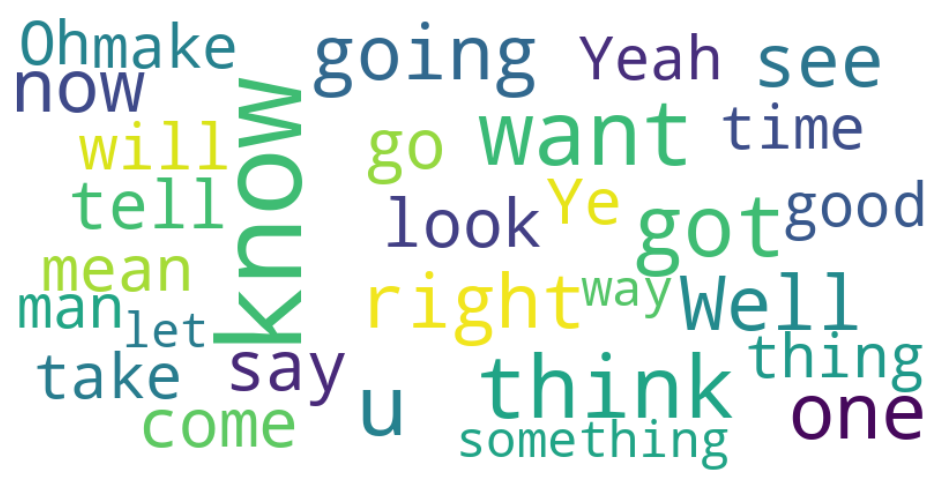

In [16]:
wordcloud = WordCloud(max_font_size=100, max_words=30, background_color="white",
                          width=800, height=400).generate(' '.join(df_lines['text']))

plt.figure(figsize=(18,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Last graph is still considering stopwords mentioned in the dialogs, let's try to show them without them

In [17]:
lines = df_lines['clean_text']

vec = CountVectorizer(ngram_range=(1,1),stop_words = 'english').fit(lines)
bag_of_words = vec.transform(lines)

sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
common_words = words_freq[:30]

df = pd.DataFrame(common_words, columns = ['LinesText' , 'count'])
df = df.set_index('LinesText')
df

,count
LinesText,
know,21747
just,15693
like,14941
did,14494
got,11482
want,11038
think,10749
right,9969
going,8860


Good, now let's see for the other statistics of the dataset, where we have the movie ratings, genres, years, and others. We can do some cool graphs for those as well, for example let's plot a boxplot to see the IMDB rating by genre

<ipython-input-18-fece6a0f1cc0>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='genres', y='IMBD_rating', data=genre_df, palette='Set3')


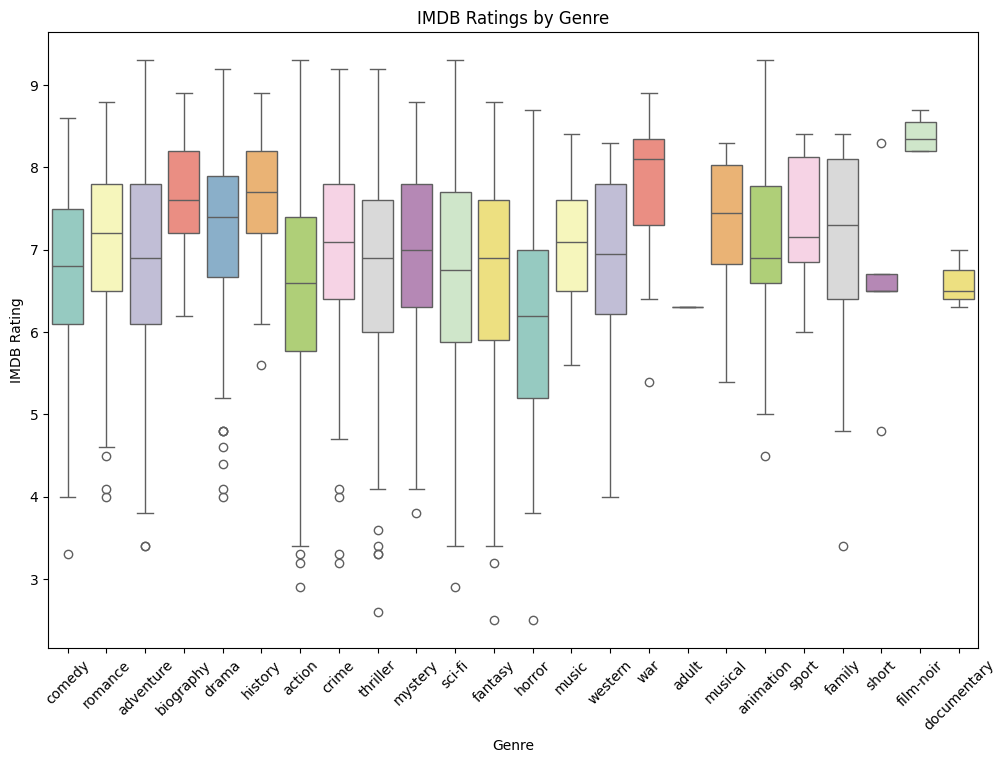

In [18]:
genre_df = df_title.explode('genres')
genre_df = genre_df.reset_index(drop=True)

plt.figure(figsize=(12, 8))
sns.boxplot(x='genres', y='IMBD_rating', data=genre_df, palette='Set3')
plt.xlabel('Genre')
plt.ylabel('IMDB Rating')
plt.title('IMDB Ratings by Genre')
plt.xticks(rotation=45)
plt.show()

That is interesting!
Let's try now a scatter plot of IMDB rating vs. year

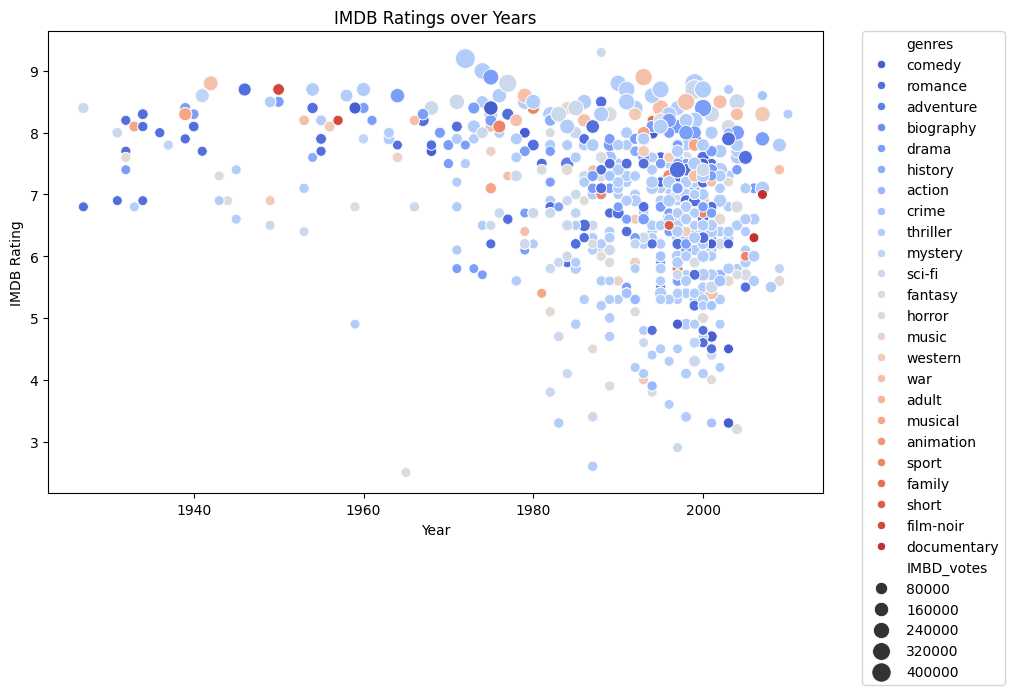

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='year', y='IMBD_rating', data=genre_df, hue='genres', palette='coolwarm', size='IMBD_votes', sizes=(50, 200))
plt.xlabel('Year')
plt.ylabel('IMDB Rating')
plt.title('IMDB Ratings over Years')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

We can see that the distribution of the data tends to the more recent movies. Older movies have less data to work with. But also newermovies are the ones with worst ratings.

## 1.2 Text Clustering


### K-means Cluster by Genre (R)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

##Any term that appears in more than 30% of the documents will be ignored
vectorizer = TfidfVectorizer(max_df=0.3, min_df=5, stop_words='english')

# Get only the dialogues from the dialog_df and drop the other columns
df_dialogues = dialog_df.drop(["speaker1_ID", "speaker2_ID"], axis=1)
df_dialogues = df_dialogues.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# Gather all the dialogues from the same movie
df_dialogues_aggregated = df_dialogues.groupby('movie_ID')['dialog'].apply(lambda x: ' '.join(x)).reset_index()

genres_list = []
for i in range(len(df_dialogues_aggregated["dialog"])):
  # Add the genres and dialogues token in front of the approppiate positions
  genres_list.append(df_title[df_title["movie_ID"] == df_dialogues_aggregated.iloc[i]["movie_ID"]]["genres"].tolist()[0])
df_dialogues_aggregated["genres"] = genres_list

In [ ]:
df_dialogues_aggregated

,movie_ID,dialog,genres
0,m0,can we make this quick roxanne korrine and an...,"[comedy, romance]"
1,m1,i never seen heat like this not even in las m...,"[adventure, biography, drama, history]"
2,m10,you got yourself a computer alma;been putting ...,"[drama, mystery, thriller]"
3,m100,i said something;i know you did no not her me;...,"[action, adventure, comedy, crime, sci-fi]"
4,m101,hi honey;hi daddy;what is new;ms laufer gave m...,"[biography, drama, thriller]"
...,...,...,...
612,m95,you think i am i am an animal;no i ca not...,"[drama, sci-fi, thriller]"
613,m96,son are you awake;yes we are going to be movi...,"[horror, sci-fi]"
614,m97,penicillin at least it will help keep his feve...,"[action, adventure, sci-fi, thriller]"
615,m98,oh sallah what a relief;marcus brody sir and w...,"[action, adventure, thriller, action, adventur..."


In [ ]:
vector_lines = vectorizer.fit_transform(df_dialogues_aggregated['dialog'])
vocab = vectorizer.get_feature_names_out()

print(f"Length of vocabulary: {len(vocab)}")

Length of vocabulary: 12805


In [ ]:
k = 24 ##number of genres
kmeans = KMeans(n_clusters=k, max_iter=100, n_init=2, verbose=True, random_state=2307)
kmeans.fit(vector_lines)

Initialization complete
Iteration 0, inertia 1044.747899312012.
Iteration 1, inertia 558.3876349570846.
Iteration 2, inertia 557.1307788480906.
Iteration 3, inertia 556.5793277559372.
Iteration 4, inertia 556.0577328353666.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 1030.2198870273528.
Iteration 1, inertia 555.4026717882919.
Iteration 2, inertia 554.6470280170911.
Iteration 3, inertia 554.610140210877.
Converged at iteration 3: strict convergence.


KMeans(max_iter=100, n_clusters=24, n_init=2, random_state=2307, verbose=True)

We will now output the top terms for some of the clusters.

In [ ]:
print("Top terms per cluster:")
vocab = vectorizer.get_feature_names_out()

for i in range(k):
    centroid = kmeans.cluster_centers_[i]
    sorted_terms = centroid.argsort()[::-1]
    print(f"Cluster {i}:\t{[vocab[j] for j in sorted_terms[:10]]}")

Top terms per cluster:
Cluster 0:	['max', 'neil', 'freddy', 'krueger', 'nancy', 'dreams', 'lenny', 'jesse', 'batman', 'bruce']
Cluster 1:	['ok', 'jimmy', 'brad', 'frank', 'claudia', 'janet', 'rose', 'daddy', 'earl', 'dr']
Cluster 2:	['president', 'general', 'dr', 'army', 'tyler', 'major', 'snake', 'baron', 'stones', 'majesty']
Cluster 3:	['peter', 'lloyd', 'peel', 'date', 'madame', 'dude', 'josie', 'prom', 'eve', 'nathan']
Cluster 4:	['john', 'blade', 'ian', 'malcolm', 'kelly', 'ann', 'doe', 'sarah', 'dr', 'miles']
Cluster 5:	['jack', 'itís', 'iím', 'donít', 'eric', 'thatís', 'frank', 'david', 'bruce', 'glenn']
Cluster 6:	['nick', 'charlie', 'jerry', 'mitchell', 'continued', 'peggy', 'arcade', 'julia', 'audrey', 'eddie']
Cluster 7:	['paul', 'superman', 'walter', 'harold', 'edward', 'jimmy', 'john', 'ted', 'eve', 'lois']
Cluster 8:	['rachel', 'jamie', 'ben', 'michael', 'reed', 'myers', 'victor', 'sam', 'johnny', 'logan']
Cluster 9:	['ray', 'claude', 'dana', 'julie', 'marty', 'mama', 'an

**The divison between genres is not very obvious. Cluster 14 may be about sci-fi movies. Cluster 20 could be about adventure or history.**

In [ ]:
print('Number of movies in: ')

for i in range(kmeans.n_clusters):
    print(f"Cluster {i}: {np.sum(kmeans.labels_ == i)}")

Number of movies in: 
Cluster 0: 21
Cluster 1: 62
Cluster 2: 38
Cluster 3: 27
Cluster 4: 24
Cluster 5: 22
Cluster 6: 17
Cluster 7: 75
Cluster 8: 13
Cluster 9: 14
Cluster 10: 18
Cluster 11: 41
Cluster 12: 10
Cluster 13: 17
Cluster 14: 39
Cluster 15: 14
Cluster 16: 35
Cluster 17: 24
Cluster 18: 14
Cluster 19: 9
Cluster 20: 30
Cluster 21: 15
Cluster 22: 25
Cluster 23: 13


In [ ]:
## Evaluation
from sklearn import metrics

print("Intrinsic evaluation measures:")
print("Within-cluster sum-of-squares:", str(kmeans.inertia_))
print("Silhouette coefficient:", str(metrics.silhouette_score(vector_lines, kmeans.labels_)))

Intrinsic evaluation measures:
Within-cluster sum-of-squares: 554.610140210877
Silhouette coefficient: 0.011143303899652303


### Topic Modeling by Genres (R)

Topic modeling is ideal for text data to understand topics and themes, so we have compared the results to K-means clustering. Topic modeling identifies underlying topics within a collection of documents, so we think it works better for finding genres. It also allows several topics to be in one document, which is consistent with our dataset where each movie is assigned to several genres.

In [ ]:
from sklearn.model_selection import train_test_split

documents_train, documents_test, label_train, label_test = train_test_split(df_dialogues_aggregated['dialog'], df_dialogues_aggregated['genres'], test_size=0.4)

print('No. training docs:', len(documents_train))
print('No. testing docs:', len(documents_test))

No. training docs: 370
No. testing docs: 247


We use CountVectorizer here because LDA works well with it. CountVectorizer models the word count distributions directly. The simplicity and straightforwardness of raw counts align well with the assumptions of LDA.

In [ ]:
count_vectorizer = CountVectorizer(stop_words='english',min_df=5,max_df=.3)
count_vector_documents_train = count_vectorizer.fit_transform(documents_train)

In [ ]:
cv_vocab = count_vectorizer.get_feature_names_out()
len(cv_vocab)

9018

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

cv24_lda = LatentDirichletAllocation(n_components=24, verbose=1, learning_method='online', max_iter=30)
cv24_lda.fit(count_vector_documents_train)

iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_iter: 30
iteration: 5 of max_iter: 30
iteration: 6 of max_iter: 30
iteration: 7 of max_iter: 30
iteration: 8 of max_iter: 30
iteration: 9 of max_iter: 30
iteration: 10 of max_iter: 30
iteration: 11 of max_iter: 30
iteration: 12 of max_iter: 30
iteration: 13 of max_iter: 30
iteration: 14 of max_iter: 30
iteration: 15 of max_iter: 30
iteration: 16 of max_iter: 30
iteration: 17 of max_iter: 30
iteration: 18 of max_iter: 30
iteration: 19 of max_iter: 30
iteration: 20 of max_iter: 30
iteration: 21 of max_iter: 30
iteration: 22 of max_iter: 30
iteration: 23 of max_iter: 30
iteration: 24 of max_iter: 30
iteration: 25 of max_iter: 30
iteration: 26 of max_iter: 30
iteration: 27 of max_iter: 30
iteration: 28 of max_iter: 30
iteration: 29 of max_iter: 30
iteration: 30 of max_iter: 30


LatentDirichletAllocation(learning_method='online', max_iter=30,
                          n_components=24, verbose=1)

In [ ]:
count_vector_documents_test = count_vectorizer.transform(documents_test)
print(cv24_lda.perplexity(count_vector_documents_test))

8086.129844629526


In [ ]:
lda = cv24_lda

In [ ]:
import numpy as np

for i in range(len(lda.components_)):
    sorted_terms = lda.components_[i].argsort()[::-1]
    concatenated_terms = '[' + ', '.join(vocab[i] for i in sorted_terms[:10]) + ']'
    print (f'Topic {i + 1}:\t', concatenated_terms)

Topic 1:	 [radio, fertility, disagree, donut, conflict, hmmmm, prisons, outsiders, marble, eightyfive]
Topic 2:	 [groceries, fed, looka, claim, alternative, chum, owen, consistent, gay, corridor]
Topic 3:	 [fiber, language, corpses, fishing, maids, charley, prank, profanity, holiness, maneater]
Topic 4:	 [m16, mamma, bundle, godforsaken, informal, peeled, innocent, gagging, humanly, offed]
Topic 5:	 [classified, fearless, consistent, eater, growin, groceries, jenkins, grownup, courtroom, hangin]
Topic 6:	 [disturb, conversation, mental, attracted, clarity, quotes, producing, percentages, etiquette, border]
Topic 7:	 [fearless, consistent, galloping, federation, groceries, language, object, hay, arrangements, hazard]
Topic 8:	 [groceries, logic, prepare, handing, maneater, franchise, booze, impeach, bladder, niagara]
Topic 9:	 [connecticut, hast, include, gunfire, fox, m16, ants, costume, entertaining, degree]
Topic 10:	 [fiend, consistent, eater, jar, chum, peg, rainy, entering, disagr

Topic 17 could be action, Topic 19 could be crime, but these results are also not very clear.

## 1.3 Indexing
Eventhough our task is not directly related to Information Retrival, we can implement indexing with pyterrier to create a simple dialog answering algorithm.

First lets download the pyterier

In [ ]:
!pip install -q python-terrier

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.9/337.9 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) 

Now, we will use the df_lines dataframe. We need docno as a column name, so we will create a new dataframe df_index to apply indexing.

In [ ]:
df_index = df_lines
# line_id is unique so it can be the docno
df_index = df_index.rename(columns={'line_ID': 'docno'})
# We don't need the line and speaker columns so drop them
df_index = df_index.drop(['text', 'speaker'], axis=1)
df_index

KeyError: "['line'] not found in axis"

Now the dataframe is ready, we do the indexing. It may take a long time!

In [ ]:
import pyterrier as pt

# Start the pyterrier
if not pt.started():
  pt.init()

# Initialize indexer with English tokenizer
indexer_path = "./index_dialog"
indexer = pt.DFIndexer(indexer_path, overwrite=True, tokeniser="EnglishTokeniser")

# Create the indexing, the metadata (second input) is the entire dataframe since we dropped the unnecessary columns
index_ref = indexer.index(df_index['clean_text'], df_index)

We can get the statistics of our indexing. We can access the set of terms ie. our vocabulary using `\index.getLexicon()` method. Below we only print the first 10 terms since the vocabulary is quite huge. Also it is important to mention that the first terms are all numbers.

In [ ]:
# Get the index
index = pt.IndexFactory.of(index_ref)

# Set to print the first 10 terms
limit = 10
for kv in index.getLexicon():
    print(kv.getKey(),":", kv.getValue().toString())
    limit -= 1
    if limit == 0: break

Now, let us define the 3 retrievers we've seen in class and use them for our queries.

1.   **Term Frequency (TF)** $$ TF_{t,d} = \frac{\text{Number of times term t appears in document d}}{\text{Total number of terms in document d}} $$
2.   **Term Frequency-Inverse Document Frequency (TF-IDF)** $$ \text{TF-IDF}_{t,d} = TF_{t,d} \times IDF_t $$ where $IDF_t$ is the **inverse document frequency.**
3.   **BM25** $$BM25_{t,d} = IDF_{t} \times \frac{(k_1 + 1) \times TF_{t,d}}{k_1 \times ((1 - b) + b \times \frac{\text{length of document d}}{\text{average document length}}) + TF_{t,d}}$$


We query a simply input `Hello, how are you feeling today` and print the first 5 results from each retrievers using the rank cut-off operator `%`

In [ ]:
# Initialize the retrievers
tf = pt.BatchRetrieve(index, wmodel="Tf")
tf_idf = pt.BatchRetrieve(index, wmodel="TF_IDF")
bm25 = pt.BatchRetrieve(index, wmodel="BM25")

query = 'Hello, how are you feeling today'

# Print the scores
print("TF:\n", (tf % 5).search(query))
print("TF-IDF:\n", (tf_idf % 5).search(query))
print("BM25:\n", (bm25 % 5).search(query))

We get similar results with TF-IDF and BM25. BM25 results have the highest scores and TF scores are the lowest. We can say that BM25 performs the best compared to the others.


The results look good but to evaulate the results we need to see the sentences we retrieve! To do that let's create a function called `get_line(line_ID)` which returns the line with the corresponding `line_ID` using the `df_lines`. (We can also use `df_index` with `docno` instead of `line_ID`). Then we can use this function to print the corresponding lines.

In [ ]:
def get_line(line_ID):
  try:
    return df_lines[df_lines['line_ID'] == line_ID]['clean_text'].values[0]
  except:
    return "Line_ID not found!"

# TF
# For now, we don't need the other columns, so only get docno and score
tf_results = (tf % 5).search(query)[['docno', 'score']]
# Create a new column with the line value
tf_results["line"] = [get_line(id) for id in tf_results['docno'].tolist()]
print("TF:\n", tf_results)

# TF-IDF
tfidf_results = (tf_idf % 5).search(query)[['docno', 'score']]
tfidf_results["line"] = [get_line(id) for id in tfidf_results['docno'].tolist()]
print("TF-IDF:\n", tfidf_results)

# BM25
bm_results = (bm25 % 5).search(query)[['docno', 'score']]
bm_results["line"] = [get_line(id) for id in bm_results['docno'].tolist()]
print("BM25:\n", bm_results)

## 1.4 Training a Word2Vec embedding

We are going to train a Word2Vec embedding. This word embedding gives us a numerical representation of the words that keep relation among them, similar words like 'bad' and 'dislike' will probably be mapped close in the vector space, which means they'll keep the meaning they originally had. This is used to feed almost all language processing algorithms, as it's far easier for a machine to process numbers than words themselves.

We will install the gensim package that already has an implementation of a Word2Vec embedding


In [20]:
!pip install --upgrade gensim

The Word2Vec embedding only uses sentences as training data, therefore we will use the lines dataframe.

Now we can proceed to do some cleaning of the data:
- remove non-letter characters from each sentence
- lowercase
- tokenize the sentences based on whitespace
- remove any sentence with length less than 2 since it won't be useful for training Word2Vec.

In [21]:
tokenized_sentences = [re.sub('\W', ' ', sentence).lower().split() for sentence in df_lines['clean_text']]
# remove sentences that are only 1 word  long
tokenized_sentences = [sentence for sentence in tokenized_sentences if len(sentence) > 1]

for sentence in tokenized_sentences[:10]:
    print(sentence)

['they', 'do', 'not']
['they', 'do', 'to']
['i', 'hope', 'so']
['she', 'okay']
['let', 's', 'go']
['okay', 'you', 'are', 'gonna', 'need', 'to', 'learn', 'how', 'to', 'lie']
['i', 'am', 'kidding', 'you', 'know', 'how', 'sometimes', 'you', 'just', 'become', 'this', 'persona', 'and', 'you', 'do', 'not', 'know', 'how', 'to', 'quit']
['like', 'my', 'fear', 'of', 'wearing', 'pastels']
['the', 'real', 'you']
['what', 'good', 'stuff']


Finally we have the data in the right format for training Word2Vec, so we can provide it to the algorithm. For parameters, we set:
- the embedding size to be 30,
- the minimum count for any vocabulary term to be 5
- the size of the context window to 10.

In [22]:
from gensim.models.word2vec import Word2Vec

Word2VecModel = Word2Vec(tokenized_sentences, vector_size=30, min_count=5, window=10)

Let's see how big the vocabulary is that Word2Vec ended up using, i.e. how many word vectors did it learn:

In [23]:
len(Word2VecModel.wv)

17464

### Inspecting embeddings and finding similar words

Now that we have a word2vec model trained, what can we do with it?
- Let's print out one of the vectors to see what it looks like:

In [24]:
term = 'car'
Word2VecModel.wv[term]

array([ 2.602345  ,  0.790411  ,  0.6580712 ,  3.781379  , -0.86328113,
       -1.8011205 , -0.5582186 , -0.7813946 , -0.6054731 , -2.73915   ,
        1.2777396 ,  3.9340446 ,  0.639478  ,  3.6205974 , -0.22350623,
       -3.0142796 , -0.932184  , -0.7792168 ,  1.1625277 ,  1.4262608 ,
        1.2873342 , -0.1071703 ,  0.28084517,  0.41471002, -2.867413  ,
       -0.12680939,  1.1281347 ,  1.9736696 ,  3.0585325 ,  2.923552  ],
      dtype=float32)

Unlike LDA's document topic vector, this one has both positive and negative values.

We could now use the model to compute similarities between terms based on their cosine distance in the embedding space.
- Try modifying the terms below to see what their closest neighbouring terms are:
  - Some good terms to try are: hockey, mouse, god, microsoft, clinton, bush, etc.
  - (If yuo see an error, that is because the term you chose is not in the dictionary.)

In [25]:
# term = 'life'
# term = 'escape'
# term ='love'

Word2VecModel.wv.most_similar(term)

[('truck', 0.9124155640602112),
 ('bathroom', 0.8498913049697876),
 ('bag', 0.8369016647338867),
 ('gun', 0.8295843601226807),
 ('head', 0.8172557950019836),
 ('store', 0.8102636933326721),
 ('bus', 0.8087738752365112),
 ('boat', 0.8077802062034607),
 ('apartment', 0.798995852470398),
 ('hole', 0.7945092916488647)]

### Visualising the embedding vectors using t-SNE

We'll now visualise some of the word vectors in a 3 dimensional space using t-SNE.

The vocabulary of word vectors is quite large (around 25,000). Giving them all to t-SNE will cause it to take far too long to converge.
- So let's first choose a random subset of 500 terms to show:

In [26]:
import random

sample = random.sample(list(Word2VecModel.wv.key_to_index), 500)
print(sample)

['disability', 'vito', 'puttin', 'gunderson', 'damnation', 'crank', 'confident', 'toni', 'charts', 'putting', 'faculty', 'structural', 'payne', 'classes', 'flattery', 'galley', 'cornwallis', 'doesnít', 'chained', 'plague', 'nosy', 'midwest', 'reprieve', 'hoss', 'velvet', 'choppers', 'godzilla', 'perrier', 'sweating', 'va', 'notes', 'afterwards', 'gruesome', 'skywalker', 'plants', 'mustard', 'almost', 'fiji', 'accepted', 'representatives', 'firm', 'inquire', 'testify', 'blunt', 'frantic', 'jeriko', 'tart', 'leads', 'cans', 'humans', 'expanded', 'slippers', 'hearse', 'macneil', 'rely', 'whatsoever', 'fierce', 'bangin', 'daffy', 'francis', 'dooley', 'impostor', 'sheer', 'dedication', 'polite', 'prettiest', 'easiest', 'jan', 'notdo', 'toby', '39', 'sculpture', '10000', 'introduce', 'abducted', 'delacroix', 'idea', 'boycott', 'titanium', 'convicted', 'hatchet', 'grier', 'welded', 'platoon', 'knows', 'cy', 'releases', 'feldman', 'matches', 'trim', 'running', 'tragic', 'dreyer', 'titles', 'fa

Now we'll get the word vectors for the sampled terms:

In [27]:
word_vectors = Word2VecModel.wv[sample]
word_vectors

array([[ 0.03937291, -0.11492063,  0.085063  , ..., -0.01569433,
         0.0533652 , -0.0648085 ],
       [ 0.15356088, -0.32121024,  0.23312137, ...,  0.22040576,
         0.16632758, -0.49841306],
       [ 0.42164326, -0.28657573,  0.04213208, ...,  0.42146814,
         0.27241278, -0.76704884],
       ...,
       [ 0.00213119, -0.4538863 ,  0.1807707 , ...,  0.2298932 ,
         0.0732034 , -0.3135619 ],
       [ 0.28394744, -0.61549646,  0.3340478 , ..., -1.4679666 ,
         0.75892013, -1.7024091 ],
       [-0.00873846, -0.34363905,  0.16369203, ...,  0.20565504,
         0.15460034, -0.5649934 ]], dtype=float32)

And we'll provide the vectors to TSNE to fit a model and transform the data to 3 dimensions:

In [28]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, n_iter=2000)
tsne_embedding = tsne.fit_transform(word_vectors)

Now transform the data into 3 columns (for x, y, and z):

In [29]:
x, y, z = np.transpose(tsne_embedding)

And generate the 3d plot:

In [30]:
!pip install plotly

In [31]:
import plotly.express as px

fig = px.scatter_3d(x=x, y=y, z=z)
fig.update_traces(marker=dict(size=3,line=dict(width=2)))
fig.show()

Well that's a not a particularly interesting 3d plot!
- How about we label some of the points on the graph to see what words they correspond to:

In [32]:
fig = px.scatter_3d(x=x[:200],y=y[:200],z=z[:200],text=sample[:200])
fig.update_traces(marker=dict(size=3,line=dict(width=2)),textfont_size=10)
fig.show()

Let's extend the random set of terms with a set of colours to see if they cluster:

In [33]:
# Add some specific terms to sample:
colours = ['red','green','blue','orange','yellow','purple','pink','cream','brown','black','white','gray']

word_vectors = Word2VecModel.wv[colours+sample] #colors+sample

tsne = TSNE(n_components=3)
tsne_embedding = tsne.fit_transform(word_vectors)

x, y, z = np.transpose(tsne_embedding)

In [34]:
import plotly.express as px

r = (-200,200)
fig = px.scatter_3d(x=x, y=y, z=z, range_x=r, range_y=r, range_z=r, text=colours + [None] * 500)
fig.update_traces(marker=dict(size=3,line=dict(width=2)),textfont_size=10)
fig.show()

Note: t-SNE is a stochastic algorithm, so run it a couple of times to see how the visualisation changes.

Have a play around with the visualisation to see whether other sets of terms cluster together.

### Neighbourhood-based analysis ()


We will also try to visualize the neighbours of the sum of the famous analogy between the king, woman and man:

In [35]:
vec = Word2VecModel.wv.most_similar(Word2VecModel.wv['king'] + (Word2VecModel.wv['woman'] - Word2VecModel.wv['man']))
vec

[('child', 0.7415590882301331),
 ('princess', 0.6771256327629089),
 ('woman', 0.6477994322776794),
 ('queen', 0.6430022716522217),
 ('king', 0.6400929689407349),
 ('death', 0.6369908452033997),
 ('simone', 0.6195023059844971),
 ('birth', 0.6082955598831177),
 ('suffering', 0.606532096862793),
 ('natural', 0.5903052687644958)]

And we will also try to visualize if there is a relation between the distances of pair of vectors that should be correlated. An example would be man and woman with girl and boy or queen and king. Let's see!

We get the difference between the word 'man' and the word 'woman'. Then we get, for example, the word 'boy' and subtract the previous difference, in the words near to the resulting vector we should find the word 'girl'.

In [36]:
difference = Word2VecModel.wv['man'] - Word2VecModel.wv['woman']
Word2VecModel.wv.most_similar(Word2VecModel.wv['boy']-difference)

[('girl', 0.8221831917762756),
 ('woman', 0.7901695966720581),
 ('lady', 0.7547472715377808),
 ('mother', 0.7343083620071411),
 ('sister', 0.7178102135658264),
 ('child', 0.6876686811447144),
 ('boy', 0.6783772706985474),
 ('dress', 0.6732936501502991),
 ('she', 0.6656879186630249),
 ('wife', 0.657721221446991)]

In [37]:
difference = Word2VecModel.wv['man'] - Word2VecModel.wv['woman']
Word2VecModel.wv.most_similar(Word2VecModel.wv['king']-difference)

[('child', 0.7415590882301331),
 ('princess', 0.6771256327629089),
 ('woman', 0.6477994322776794),
 ('queen', 0.6430022716522217),
 ('king', 0.6400929689407349),
 ('death', 0.6369908452033997),
 ('simone', 0.6195023059844971),
 ('birth', 0.6082955598831177),
 ('suffering', 0.606532096862793),
 ('natural', 0.5903052687644958)]

This way, we are proving 3 things we saw in the theory:
- certain directions in the space have meaning
- semantics is often additive
- analogies are encoded in the embedding

Let's try with another example, in this case we want to see if the neighbours of the word murderer have any relationship with the word itself

In [38]:
Word2VecModel.wv.most_similar(Word2VecModel.wv['murderer'])

[('murderer', 1.0),
 ('policeman', 0.8228230476379395),
 ('monster', 0.791313886642456),
 ('werewolf', 0.7889838814735413),
 ('killer', 0.7811750769615173),
 ('priest', 0.7775033712387085),
 ('prince', 0.7756093740463257),
 ('businessman', 0.7682098150253296),
 ('fighter', 0.7655013799667358),
 ('goon', 0.7648854851722717)]

This way, we are able to see that the embedding we've created kind of 'understands' the underlying meaning of the word and in this case it's matched up with words that semantically similar or even synonims like assasin.

Another important characteristic to note is that Word2Vec doesn't work with ngrams. Therefore, it will not be able to process any word that is not in the feature space, for example, confuzzling:

In [39]:
try:
  Word2VecModel.wv.most_similar(Word2VecModel.wv['confuzzling'])
except:
  print('Error: Key not found')

Error: Key not found


# 2.Training Models

In this section we develop the main task of our dataset, which in this case is to train and test pretrained models to generate dialog.

We decided our input is a line of dialog, e.g. "Alicia, help me!" and our output is a predicted text of what might be a real response to that phrase.

We also perform a model to predict the metadata of a dialog line as a second task for this dataset.

## 2.1 Model from scratch

A first attempt to complete this task is to train a model from "scratch"

### Tokenize the vocabulary

We define de length of the vocabulary and the embedding dimension

In [ ]:
VOCAB_SIZE = 5000 # len(keras_tokenizer.word_index) + 1
print(VOCAB_SIZE)
EMBEDDING_DIM = 500

5000


We extract the clean text lines and put them in a list

In [ ]:
dialogue_lines = []
for line in df_lines['clean_text']:
  dialogue_lines.append(line.strip())

In [ ]:
dialogue_lines[:10]

['they do not',
 'they do to',
 'i hope so',
 'she okay',
 "let's go",
 'wow',
 'okay  you are gonna need to learn how to lie',
 'no',
 'i am kidding  you know how sometimes you just become this persona  and you do not know how to quit',
 'like my fear of wearing pastels']

We fit the tensorflow keras tokenizer on our vocabulary. This tokenizer assigns lower indexes to the most frequent words. Therefore, the first words we find are usually stop words.

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from statistics import median
keras_tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}\t\n')
keras_tokenizer.fit_on_texts(dialogue_lines)


In [ ]:
keras_tokenizer.word_index

{'you': 1,
 'i': 2,
 'the': 3,
 'to': 4,
 'not': 5,
 'a': 6,
 'is': 7,
 'it': 8,
 'do': 9,
 'that': 10,
 'and': 11,
 'are': 12,
 'of': 13,
 'what': 14,
 'in': 15,
 'have': 16,
 'me': 17,
 'we': 18,
 'he': 19,
 'am': 20,
 'this': 21,
 'for': 22,
 'know': 23,
 'was': 24,
 'will': 25,
 'your': 26,
 'my': 27,
 'on': 28,
 'be': 29,
 'no': 30,
 "it's": 31,
 'with': 32,
 'but': 33,
 'they': 34,
 'just': 35,
 'would': 36,
 'all': 37,
 'like': 38,
 'did': 39,
 'get': 40,
 'about': 41,
 'out': 42,
 'so': 43,
 'if': 44,
 'here': 45,
 'she': 46,
 'him': 47,
 'up': 48,
 'got': 49,
 'how': 50,
 'can': 51,
 'want': 52,
 'think': 53,
 'at': 54,
 'there': 55,
 'one': 56,
 'right': 57,
 'go': 58,
 'now': 59,
 'well': 60,
 'her': 61,
 'going': 62,
 'why': 63,
 'see': 64,
 'as': 65,
 'oh': 66,
 'his': 67,
 'good': 68,
 'yes': 69,
 'who': 70,
 'could': 71,
 'when': 72,
 'from': 73,
 'yeah': 74,
 'tell': 75,
 'where': 76,
 'were': 77,
 'come': 78,
 'ca': 79,
 'some': 80,
 'an': 81,
 'time': 82,
 'or': 83,
 

We also save the numerical representation of the lines of the dialogues. This representation is obtained by the method texts_to_sequences of the keras tokenizer. Right here we are setting the size of the training data for the model.

In [ ]:
text_sequences = keras_tokenizer.texts_to_sequences(dialogue_lines)[:5000]

In [ ]:
MAX_SEQUENCE_LENGTH = int(median(len(sequence) for sequence in text_sequences))
print(MAX_SEQUENCE_LENGTH)

7


### Build Neural Network

In [ ]:
from tensorflow.keras import backend as K
K.clear_session()

In [ ]:
from keras import backend as K
from tensorflow.keras.layers import Layer, InputSpec, TimeDistributed, Bidirectional
from keras.layers import Input, Dense, RepeatVector, LSTM, Conv1D, Masking, Embedding
from keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# Creates a dictionary with the index of the tokenizer as keys and the words as values
index2word_map = inv_map = {v: k for k, v in keras_tokenizer.word_index.items()}

#Converts the numerical sequence back into the string representation
def sequence_to_str(sequence):
    word_list = list()
    for element in sequence:
        index = np.argmax(element) + 1
        word = index2word_map[index]
        word_list.append(word)

    return word_list

To feed the model all the training data must be the same size. Therefore we use the function pad_sequences to make the vector representation of all the words the same length. The padding indicates where to put the missing 0's. In this case, it will be on the right as the padding is specified as 'post'.

In [ ]:
x_train = pad_sequences(text_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post',
                        truncating='post', value=0)

In [ ]:
x_train.shape

(5000, 7)

In [ ]:
x_train_rev = []
for x_vector in x_train:
    x_rev_vector = []
    for index in x_vector:
        char_vector = np.zeros(VOCAB_SIZE)
        char_vector[index] = 1
        x_rev_vector.append(char_vector)
    x_train_rev.append(np.asarray(x_rev_vector))
x_train_rev = np.asarray(x_train_rev)

In [ ]:
x_train_rev.shape

(5000, 7, 5000)

We also drop the frames to free some of the RAM and be able to train a slightly bigger model.

In [ ]:
import gc

del(df_lines)
del(df_conv)
del(df_title)
del(df_chars)

gc.collect()
df=pd.DataFrame()

This function generates the new sequence to sequence model.

In [ ]:
def get_seq2seq_model():
    main_input = Input(shape=x_train[0].shape, dtype='float32', name='main_input')
    print(main_input)

    embed_1 = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM,
                        mask_zero=True, input_length=MAX_SEQUENCE_LENGTH) (main_input)
    print(embed_1)

    lstm_1 = Bidirectional(LSTM(2048, name='lstm_1'))(embed_1)
    print(lstm_1)

    repeat_1 = RepeatVector(MAX_SEQUENCE_LENGTH, name='repeat_1')(lstm_1)
    print(repeat_1)

    lstm_3 = Bidirectional(LSTM(2048, return_sequences=True, name='lstm_3'))(repeat_1)
    print(lstm_3)

    softmax_1 = TimeDistributed(Dense(VOCAB_SIZE, activation='softmax'))(lstm_3)
    print(softmax_1)

    model = Model(main_input, softmax_1)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model
seq2seq_model = get_seq2seq_model()
seq2seq_model.fit(x_train, x_train_rev, batch_size=128, epochs=20, verbose=1)
predictions = seq2seq_model.predict(x_train)
index2word_map = inv_map = {v: k for k, v in keras_tokenizer.word_index.items()}

<KerasTensor shape=(None, 7), dtype=float32, sparse=None, name=main_input>
<KerasTensor shape=(None, 7, 500), dtype=float32, sparse=False, name=keras_tensor>


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, name=keras_tensor_2>
<KerasTensor shape=(None, 7, 4096), dtype=float32, sparse=False, name=keras_tensor_3>
<KerasTensor shape=(None, 7, 4096), dtype=float32, sparse=False, name=keras_tensor_4>
<KerasTensor shape=(None, 7, 5000), dtype=float32, sparse=False, name=keras_tensor_5>
Epoch 1/20
 1/40 ━━━━━━━━━━━━━━━━━━━━ 33:04 51s/step - accuracy: 0.0156 - loss: 8.5171

KeyboardInterrupt: 

Now we check the predictions of our trained model made over the dialog training dataset.

In [ ]:
for i in range(len(predictions)):
        predicted_word_list = sequence_to_str(predictions[i])
        actual_len = len(dialogue_lines[i])

        actual_sentence = "Actual: " + dialogue_lines[i][:len(dialogue_lines[i])-3]

        generated_sentence = ""
        for word in predicted_word_list:
            generated_sentence += word + " "

        sent_dict = dict()
        sent_dict["actual"] = actual_sentence.strip()
        sent_dict["generated"] = generated_sentence.strip()
        print(sent_dict)


### Trained models (R)

This first model was trained with 10,000 data entries and 10 epochs

In [ ]:
small_model = joblib.load('1stseq2seq_model.pkl')

In [ ]:
inputs = []
inputs.append('Karen: Get out of here, run as fast as you can')
inputs.append('BOB: I will not run, I will not leave you behind')
inputs.append('ROMEO: Marry me Juliet, I am in love with you')
inputs.append('SOFIA: Please, let me love you')

for i in range(len(inputs)):
        input_sentence = "Input: " + inputs[i]

        text_sequence = keras_tokenizer.texts_to_sequences(input_sentence)
        x_try = pad_sequences(text_sequence, maxlen=MAX_SEQUENCE_LENGTH, padding='post',
                        truncating='post', value=0)
        new_prediction = small_model.predict(x_try)
        predicted_word_list = sequence_to_str(new_prediction)



        generated_sentence = ""
        for word in predicted_word_list:
            generated_sentence += word + " "

        sent_dict = dict()
        sent_dict["input"] = input_sentence.strip()
        sent_dict["generated"] = generated_sentence.strip()
        print(sent_dict)


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step
{'input': 'Input: Karen: Get out of here, run as fast as you can', 'generated': 'crab crab crab crab crab crab crab crab crab crab knocks crab crab crab crab knocks crab crab crab crab crab crab crab impasse crab crab knocks crab knocks crab crab crab crab crab crab crab knocks crab impasse crab knocks crab crab crab knocks crab crab crab crab crab crab crab crab'}
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
{'input': 'Input: BOB: I will not run, I will not leave you behind', 'generated': 'crab crab crab crab crab crab crab crab crab crab crab crab crab crab crab crab crab crab crab crab crab crab crab crab crab crab crab crab crab crab crab crab crab crab crab crab crab crab crab crab knocks crab crab knocks crab crab crab crab crab crab knocks crab crab crab crab'}
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
{'input': 'Input: ROMEO: Marry me Juliet, I am in love with you', 'generated': 'crab crab crab crab crab crab crab crab crab crab knocks crab crab crab crab c

## 2.2 Fine-tuning the T5 Model

After tranining a model from scracth, we further tried to fine-tune a pre-trained model to see if we will get better results. For this task, we choose T5 encoder-decoder model which is pre-trained on a multiple tasks. It is not trained specifically on dialog data so, it is a good candidate for our task.

- We did not choose BERT because it is mainly for masked LM tasks and generative tasks are not very suitable for BERT.

- Althought, we try GPT-2 in the next chapter, it is not the best model to work with because it is poor on detecting the structure of the task and is better for a general text generation task.

### Dowloading libraries

In [ ]:
pip install torch transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 6.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
!pip install tensorflow==2.16.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 42.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 58.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 51.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 29.8 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Fo

In [ ]:
pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 4.6 MB/s eta 0:00:00


### Preparing the Data

We need to add tokens to our data to train the model. So, first we create a new dataframes based on `df_lines` called `df_token_lines`, and `df_token_dialog` based on `df_dialog`.  

In [ ]:
# Specify the special speaker token
speaker_token = "<|speaker|>"

# Create the new lines dataframe
df_token_lines = pd.DataFrame()
df_token_lines['line_ID'] = df_lines['line_ID']
df_token_lines['speaker_ID'] = df_lines['speaker_ID']
# Get the line by adding the speaker token in front
df_token_lines['clean_line'] = speaker_token + df_lines['clean_line']

# Create the new dialogues dataframe

# Same code from creating df_dialog
df_conv['index'] = df_conv.index
expanded_lines = df_conv.explode('lines_list')
expanded_lines.reset_index(drop=True, inplace=True)
# merge the line with line ids
df_token_dialog = pd.merge(
    expanded_lines,
    df_token_lines,
    left_on='lines_list',
    right_on='line_ID',
    how='inner'
)

# Select relevant columns and group by the guide index
df_token_dialog = df_token_dialog[['speaker1_ID', 'speaker2_ID', 'movie_ID', 'lines_list', 'index', 'clean_line']]
df_token_dialog = df_token_dialog.groupby(['index','speaker1_ID', 'speaker2_ID', 'movie_ID'])['clean_line'].apply(list).reset_index()
df_token_dialog = df_token_dialog.rename(columns={'clean_line': 'dialog'})
df_token_dialog = df_token_dialog.drop(['index'], axis=1)
## Remove the list
df_token_dialog['dialog'] = df_token_dialog['dialog'].apply(lambda x: '\n'.join(x))

df_token_dialog

,speaker1_ID,speaker2_ID,movie_ID,dialog
0,u0,u2,m0,[<|speaker|>BIANCA: can we make this quick ro...
1,u0,u2,m0,[<|speaker|>BIANCA: you are asking me out tha...
2,u0,u2,m0,[<|speaker|>BIANCA: no no it's my fault we di...
3,u0,u2,m0,"[<|speaker|>CAMERON: why, <|speaker|>BIANCA: u..."
4,u0,u2,m0,[<|speaker|>BIANCA: gosh if only we could find...
...,...,...,...,...
83092,u9028,u9031,m616,[<|speaker|>COGHILL: do you think she might be...
83093,u9028,u9031,m616,[<|speaker|>COGHILL: choose your targets men t...
83094,u9030,u9034,m616,[<|speaker|>VEREKER: colonel durnford william ...
83095,u9030,u9034,m616,"[<|speaker|>DURNFORD: your orders mr vereker, ..."


Now, we have a dataframe with dialogues tokenized! Let's see an example data.

In [ ]:
df_token_dialog['dialog'][0]

"<|speaker|>BIANCA: can we make this quick  roxanne korrine and andrew barrett are having an incredibly horrendous public break up on the quad  again\n<|speaker|>CAMERON: well i thought we would start with pronunciation if that is okay with you\n<|speaker|>BIANCA: not the hacking and gagging and spitting part  please\n<|speaker|>CAMERON: okay then how 'bout we try out some french cuisine  saturday  night"


### Model Training

We first get the data ready as input/output pairs using the `prepare_data` function. The output is each line in a dialog and input is the all the lines *before* the output. We start from the second line for output such that input is never empty.

In [ ]:
# Split each dialogue into pairs of input and response
def prepare_data(examples):
    dialogues = examples['dialog']
    input = []
    output = []
    for d in dialogues:
        lines = d.split('\n')
        # Start from the second line (index 1)
        for i in range(1, len(lines)):
            input.append("\n".join(l.strip() for l in lines[:i])) # up to output
            output.append(lines[i].strip())
    return {"input": input, "output": output}

In [ ]:
from datasets import Dataset
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Convert the DataFrame to a Dataset for the Model
dataset = Dataset.from_pandas(df_token_dialog["dialog"].to_frame())

# Initialize the tokenizer
tokenizer = T5Tokenizer.from_pretrained("t5-small")
processed_dataset = dataset.map(prepare_data, batched=True, batch_size=64, remove_columns=["dialog"])

# Tokenize the dataset
def tokenize_function(data):
    model_inputs = tokenizer(data['input'], padding="max_length", truncation=True, max_length=64)
    labels = tokenizer(data['output'], padding="max_length", truncation=True, max_length=64)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_datasets = processed_dataset.map(tokenize_function, batched=True)

# T5 requires a validation dataset, so split the data
train_test_split = tokenized_datasets.train_test_split(test_size=0.1)
train_dataset = train_test_split['train']
validation_dataset = train_test_split['test']


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/83097 [00:00<?, ? examples/s]

Map:   0%|          | 0/221616 [00:00<?, ? examples/s]

In [ ]:
import torch
# Get the device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

In [ ]:
from transformers import Trainer, TrainingArguments
import joblib

# Load the pre-trained T5 model to the GPU/CPU
model = T5ForConditionalGeneration.from_pretrained("t5-small").to(device)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-3,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_steps=10,
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
)

# Train the model
trainer.train()

# After the training, move the model to cpu and save the model
joblib.dump(model.to("cpu"), 't5_model.pkl', compress=9)

### Testing the Model (R)
Now that we have a saved fine-tuned model, we can generate some dialogues and see if it generates good lines!

In [ ]:
# First, load the model
loaded_model = joblib.load('t5_model.pkl')
tokenizer = T5Tokenizer.from_pretrained("t5-small")

prompt = "<|speaker|>BIANCA: hello how are you doing\n"

# Tokenize the input
inputs = tokenizer(prompt, return_tensors="pt", truncation=True, padding="max_length", max_length=64).to(device)

# Get the output from the model
outputs = model.generate(inputs["input_ids"], max_length=64, num_return_sequences=1, no_repeat_ngram_size=3).to(device)

# The output are tokenized, so decode them to print them
output =  tokenizer.decode(outputs[0], skip_special_tokens=True)

print("Input:", prompt, "\nOutput:", output)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Input: <|speaker|>BIANCA: Hello, how are you doing?
 
Output: |speaker|>JACK: i am a little nervous


In [ ]:
# We can generate the next lines in the dialog as well
prompt = prompt + output + "\n"
output = generate_dialogue(prompt, loaded_model, tokenizer)
print("Input:", prompt, "\nOutput:", output)

Input: <|speaker|>BIANCA: Hello, how are you doing?
|speaker|>JACK: i am a little nervous
 
Output: |speaker|>BIANCA: i am not nervous


## 2.3 Fine-tuning GPT-2

As we mentioned in Section 2.2, we tried to fine-tune GPT-2 model as well. However, we changed our task a little bit and use different input/output pairs for GPT-2.

For this task we tried to input `genres` and get the dialogues as the output.



### Preparing the Data

We create a genres dataframe and use the dialog dataframe to train the model.

In [ ]:
# Create a dataframe with only movie_ID and genres
df_genres = df_title.drop(['title', "year", "IMBD_rating", "IMBD_votes"], axis=1)
df_genres = df_genres.applymap(lambda x: x.strip() if isinstance(x, str) else x)
df_genres

,movie_ID,genres
0,m0,"[comedy, romance]"
1,m1,"[adventure, biography, drama, history]"
2,m2,"[action, crime, drama, thriller]"
3,m3,"[adventure, mystery, sci-fi]"
4,m4,"[action, comedy, crime, drama, thriller]"
...,...,...
612,m612,"[action, crime, fantasy, mystery, sci-fi, thri..."
613,m613,"[action, adventure, crime]"
614,m614,"[action, sci-fi]"
615,m615,"[comedy, sci-fi]"


In [ ]:
# Get only the dialogues from the dialog_df and drop the other columns
df_dialogues = dialog_df.drop(["speaker1_ID", "speaker2_ID"], axis=1)
df_dialogues = df_dialogues.applymap(lambda x: x.strip() if isinstance(x, str) else x)

df_dialogues

,movie_ID,dialog
0,m0,<|speaker|>BIANCA: can we make this quick rox...
1,m0,<|speaker|>BIANCA: you are asking me out that...
2,m0,<|speaker|>BIANCA: no no it's my fault we did...
3,m0,<|speaker|>CAMERON: why <|speaker|>BIANCA: uns...
4,m0,<|speaker|>BIANCA: gosh if only we could find ...
...,...,...
83092,m616,<|speaker|>COGHILL: do you think she might be ...
83093,m616,<|speaker|>COGHILL: choose your targets men th...
83094,m616,<|speaker|>VEREKER: colonel durnford william v...
83095,m616,<|speaker|>DURNFORD: your orders mr vereker <|...


In [ ]:
# Gather all the dialogues from the same movie
df_dialogues_aggregated = df_dialogues.groupby('movie_ID')['dialog'].apply(lambda x: ' '.join(x)).reset_index()

# Merge the two dataframes into one
genres_list = []
for i in range(len(df_dialogues["dialog"])):
  # Add the genres and dialogues token in front of the approppiate positions
  genres_list.append("<|genres|>" +', '.join( df_genres[df_genres["movie_ID"] == df_dialogues.iloc[i]["movie_ID"]]["genres"].tolist()[0]) + "<|dialogues|>" + df_dialogues["dialog"][i])
df_dialogues["genres"] = genres_list

df_dialogues

,movie_ID,dialog,genres
0,m0,<|speaker|>BIANCA: can we make this quick rox...,"<|genres|>comedy, romance<|dialogues|><|speake..."
1,m0,<|speaker|>BIANCA: you are asking me out that...,"<|genres|>comedy, romance<|dialogues|><|speake..."
2,m0,<|speaker|>BIANCA: no no it's my fault we did...,"<|genres|>comedy, romance<|dialogues|><|speake..."
3,m0,<|speaker|>CAMERON: why <|speaker|>BIANCA: uns...,"<|genres|>comedy, romance<|dialogues|><|speake..."
4,m0,<|speaker|>BIANCA: gosh if only we could find ...,"<|genres|>comedy, romance<|dialogues|><|speake..."
...,...,...,...
83092,m616,<|speaker|>COGHILL: do you think she might be ...,"<|genres|>action, adventure, drama, history, w..."
83093,m616,<|speaker|>COGHILL: choose your targets men th...,"<|genres|>action, adventure, drama, history, w..."
83094,m616,<|speaker|>VEREKER: colonel durnford william v...,"<|genres|>action, adventure, drama, history, w..."
83095,m616,<|speaker|>DURNFORD: your orders mr vereker <|...,"<|genres|>action, adventure, drama, history, w..."


### Model Training

Now we gathered the data, we can start training the model!

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer, DataCollatorForLanguageModeling, Trainer, TrainingArguments

# Convert the DataFrame to a Hugging Face Dataset
dataset = Dataset.from_pandas(df_dialogues[['genres']])

# Load pre-trained GPT-2 model and tokenizer
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
model = GPT2LMHeadModel.from_pretrained(model_name).to(device)

# Tokenize the dataset
tokenized_dataset = dataset.map(lambda d: tokenizer(d['genres'], return_tensors='pt', padding='max_length', truncation=True, max_length=64), batched=True)

# Initialize the data collator
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    overwrite_output_dir=True,
    num_train_epochs=5,
    per_device_train_batch_size=32,
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_dataset,
)

# Train the model
trainer.train()

# Save the model
joblib.dump(model, 'gpt2_model.pkl', compress=9)

### Testing the Model (R)

In [ ]:
import joblib

# Load Model
loaded_model = joblib.load('gpt2_model.pkl')
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

prompt = "<|genres|>comedy, romance<|dialogues|><|speaker|>"
prompt = "<|genres|>comedy, romance"

output = generate_dialogue(prompt, loaded_model, tokenizer)
print("Input:", prompt, "\nOutput:", output)


In [ ]:
prompt = "<|genres|>horror, drama<|dialogues|><|speaker|>GENERAL: We have to run\n"
output = generate_dialogue(prompt, loaded_model, tokenizer)
print("Input:", prompt, "\nOutput:", output)


## 2.4 Dialogpt (R)

In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-medium")
model = AutoModelForCausalLM.from_pretrained("microsoft/DialoGPT-medium")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/863M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
# Function to generate a response
def generate_response(model, tokenizer, prompt, max_length=1000):
    # Encode the input prompt
    input_ids = tokenizer.encode(prompt + tokenizer.eos_token, return_tensors='pt')

    # Generate response
    chat_history_ids = model.generate(input_ids, max_length=max_length, pad_token_id=tokenizer.eos_token_id)

    # Decode the response
    response = tokenizer.decode(chat_history_ids[:, input_ids.shape[-1]:][0], skip_special_tokens=True)

    return response

# Continue the conversation
while True:
    user_input = input("User: ")
    response = generate_response(model, tokenizer, user_input)
    print("Bot: ", response)

User: Hello, how are you doing?
Bot:  I'm doing well, how are you?
User: Do you know why we can see the stars?
Bot:  I don't know, but I'm pretty sure it's because of the way the light is hitting the stars.


KeyboardInterrupt: Interrupted by user

# 3. Metadata Prediction
The second task we'll be doing on our dataset is predicting the metadata for a specific dialog. That is, given a dialog line, we aim to predict the genre of the movie it would belong to, the gender of the characters and other characteristics that are not explicitly said.

## Preparing dataframes

For the character metadata prediction we only need the line and the speaker and not the whole dialog. Then we'll predict the gender and the position on the movie credits based on one line. So let's put in a single dataframe line and character metadata

In [ ]:
character_metadata = pd.merge(
    df_lines,
    df_chars,
    left_on='speaker_ID',
    right_on='character_ID',
    how='inner'

)

# Select relevant columns and group by the guide index
character_metadata = character_metadata[['line_ID', 'speaker_ID', 'movie_ID', 'speaker', 'clean_text', 'movie_title','gender','credits_pos']]
character_metadata = character_metadata.rename(columns={'clean_text': 'line'})

character_metadata

,line_ID,speaker_ID,movie_ID,speaker,line,movie_title,gender,credits_pos
0,L1045,u0,m0,BIANCA,they do not,10 things i hate about you,f,4
1,L985,u0,m0,BIANCA,i hope so,10 things i hate about you,f,4
2,L925,u0,m0,BIANCA,let's go,10 things i hate about you,f,4
3,L872,u0,m0,BIANCA,okay you are gonna need to learn how to lie,10 things i hate about you,f,4
4,L870,u0,m0,BIANCA,i am kidding you know how sometimes you just ...,10 things i hate about you,f,4
...,...,...,...,...,...,...,...,...
304708,L666522,u9034,m616,VEREKER,so far only their scouts but we have had repor...,zulu dawn,?,-1
304709,L666520,u9034,m616,VEREKER,well i assure you sir i have no desire to crea...,zulu dawn,?,-1
304710,L666372,u9034,m616,VEREKER,i think chelmsford wants a good man on the bor...,zulu dawn,?,-1
304711,L666370,u9034,m616,VEREKER,i am to take the sikali with the main column t...,zulu dawn,?,-1


And for the movie metadata prediction we will need the whole dialog. So, let's put the metadata into the dialogs dataframe to make things easier.

In [ ]:
movie_metadata = pd.merge(
    dialog_df,
    df_title,
    left_on='movie_ID',
    right_on='movie_ID',
    how='inner'
)

movie_metadata

,speaker1_ID,speaker2_ID,movie_ID,dialog,title,year,IMBD_rating,IMBD_votes,genres
0,u0,u2,m0,can we make this quick roxanne korrine and an...,10 things i hate about you,1999,6.9,62847,"[comedy, romance]"
1,u0,u2,m0,you are asking me out that is so cute what is...,10 things i hate about you,1999,6.9,62847,"[comedy, romance]"
2,u0,u2,m0,no no it's my fault we did not have a proper ...,10 things i hate about you,1999,6.9,62847,"[comedy, romance]"
3,u0,u2,m0,why;unsolved mystery she used to be really po...,10 things i hate about you,1999,6.9,62847,"[comedy, romance]"
4,u0,u2,m0,gosh if only we could find kat a boyfriend;let...,10 things i hate about you,1999,6.9,62847,"[comedy, romance]"
...,...,...,...,...,...,...,...,...,...
83092,u9028,u9031,m616,do you think she might be interested in someo...,zulu dawn,1979,6.4,1911,"[action, adventure, drama, history, war]"
83093,u9028,u9031,m616,choose your targets men that is right watch th...,zulu dawn,1979,6.4,1911,"[action, adventure, drama, history, war]"
83094,u9030,u9034,m616,colonel durnford william vereker i hear you h...,zulu dawn,1979,6.4,1911,"[action, adventure, drama, history, war]"
83095,u9030,u9034,m616,your orders mr vereker;i am to take the sikali...,zulu dawn,1979,6.4,1911,"[action, adventure, drama, history, war]"


## Vectorizing

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
vec_lines = TfidfVectorizer(max_df=0.8, min_df=5, stop_words='english', max_features=1000)

### Vectorizing lines

In [ ]:
lines_X = vec_lines.fit_transform(character_metadata['line'])
tfidf_df = pd.DataFrame(lines_X.toarray(), columns=vec_lines.get_feature_names_out())
tfidf_df

,able,absolutely,accept,accident,account,act,acting,action,actually,address,...,wrong,wrote,ya,yeah,year,years,yes,yesterday,york,young
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304708,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
304709,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
304710,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
304711,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Vectorizing dialogs

In [ ]:
vec_dial = TfidfVectorizer(max_df=0.8, min_df=5, stop_words='english', max_features=1000)

Using the vectorizer (computed in 'otherTasks' notebook) we transform de data to have the dialog in a way we can input it to the model

In [ ]:
dialog_X = vec_dial.fit_transform(movie_metadata['dialog'])
tfidf_df = pd.DataFrame(dialog_X.toarray(), columns=vec_dial.get_feature_names_out())
tfidf_df

,able,absolutely,accept,accident,account,act,acting,actually,address,admit,...,wrong,wrote,ya,yeah,year,years,yes,yesterday,york,young
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83092,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
83093,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
83094,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.21258,0.0,0.0,0.0
83095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0


## Model Creation (A)

### Character metadata models

**Input:** Line

**Output:**
Character metadata:

* gender
* position on movie *credits*

#### Gender model

The gender of a character is classified as `F`, `M` or `?`. As it has 3 classes, we must use a classifier model.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [ ]:
y_gender = character_metadata['gender']  # Real size y - to uncomment
X_in_use = lines_X  # Real size X - to uncomment

X_train, X_test, y_train, y_test = train_test_split(X_in_use, y_gender, test_size=0.2, random_state=42)

# Using RandomForestClassifier for classification
gender_model = RandomForestClassifier()
gender_model.fit(X_train, y_train)

accuracy = gender_model.score(X_test, y_test)
print('Gender Prediction Accuracy:', accuracy)

Gender Prediction Accuracy: 0.49136077974500764


Export model to not train again

In [ ]:
joblib.dump(gender_model, 'gender_model.pkl', compress=9)

['gender_model.pkl']

#### Credits position model

The position in the credits can be seen as continuous or as a categorical variable, since it's a number but it can also represent how important the character was in the movie. If characters are often ranked as "lead", "supporting", and "minor", it makes sense to classify them into categories. So we will try both Regression and Classification and for the last one classes are the position in the credits (`-1` for unknown, `1` for main character and so on, as it gets bigger the less important the character).

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
y_pos = character_metadata['credits_pos'] # real size y - to uncomment
X_in_use = lines_X # real size X - to uncomment

X_train, X_test, y_train, y_test = train_test_split(X_in_use, y_pos, test_size=0.2, random_state=42)

# Using RandomForestRegressor for regression
credits_pos_model_reg = RandomForestRegressor()
credits_pos_model_reg.fit(X_train, y_train)

accuracy = credits_pos_model_reg.score(X_test, y_test)
print('Credits position Accuracy:', accuracy)

Credits position Accuracy: -0.05991770736540669


In [ ]:
# joblib.dump(credits_pos_model_reg, 'credits_pos_model_reg.pkl', compress=9)

In [ ]:
y_pos = character_metadata['credits_pos'] # real size y - to uncomment
X_in_use = lines_X # real size X - to uncomment

X_train, X_test, y_train, y_test = train_test_split(X_in_use, y_pos, test_size=0.2, random_state=42)

# Using RandomForestClassifier for classification
credits_pos_model_clas = RandomForestClassifier()
credits_pos_model_clas.fit(X_train, y_train)

accuracy = credits_pos_model_clas.score(X_test, y_test)
print('Credits position Accuracy:', accuracy)

Credits position Accuracy: 0.2886467682916824


The score method returns the coefficient of determination R^2
The values that can take are as follows:

* R^2=1 : Indicates that the model perfectly explains the variance in the test data.
* R^2>0 : Indicates that the model has some predictive power, capturing part of the variance in the data.
* R^2=0 : Indicates that the model explains none of the variance, equivalent to using the mean of the observed values.
* R^2<0 : Indicates that the model is worse than a simple mean, meaning the model is failing to capture the variance in the data.

It looks like it has a better accuracy if the credit position is treated as a clasification. So we'll use that one.

In [ ]:
joblib.dump(credits_pos_model_clas, 'credits_pos_model_clas.pkl', compress=9)

['credits_pos_model_clas.pkl']

### Movie metadata models

**Input:** Dialog

**Output:** Movie metadata:

* genres
* release year
* IMDB rating
* number of IMDB votes

We will create a model for each metadata field

#### Release year model

In [ ]:
y_year = movie_metadata['year']  # real size y - to uncomment
X_in_use = dialog_X # real size X - to uncomment

X_train, X_test, y_train, y_test = train_test_split(X_in_use, y_year, test_size=0.2, random_state=42)

release_year_model = RandomForestRegressor()
release_year_model.fit(X_train, y_train)

accuracy = release_year_model.score(X_test, y_test)
print('Release Year Prediction Accuracy:', accuracy)

Release Year Prediction Accuracy: 0.2689944802819675


In [ ]:
joblib.dump(release_year_model, 'release_year_model.pkl', compress=9)

#### IMDB rating model

In [ ]:
y_rate = movie_metadata['IMBD_rating']  # real size y - to uncomment
X_in_use = dialog_X # real size X - to uncomment

X_train, X_test, y_train, y_test = train_test_split(X_in_use, y_rate, test_size=0.2, random_state=42)

imdb_rating_model = RandomForestRegressor()
imdb_rating_model.fit(X_train, y_train)

accuracy = imdb_rating_model.score(X_test, y_test)
print('IMDB rating Prediction Accuracy:', accuracy)

IMDB rating Prediction Accuracy: 0.27930733642047323


In [ ]:
joblib.dump(imdb_rating_model, 'imdb_rating_model.pkl', compress=9)

#### Number of votes model

In [ ]:
y_votes = movie_metadata['IMBD_votes']  # real size y - to uncomment
X_in_use = dialog_X # real size X - to uncomment

X_train, X_test, y_train, y_test = train_test_split(X_in_use, y_votes, test_size=0.2, random_state=42)

votes_model = RandomForestRegressor()
votes_model.fit(X_train, y_train)

accuracy = votes_model.score(X_test, y_test)
print('IMDB rating Prediction Accuracy:', accuracy)

KeyboardInterrupt: 

In [ ]:
joblib.dump(votes_model, 'votes_model.pkl', compress=9)

#### Genres model

This is particular case, since what we are trying to predict is a list of elements (genres). This problem is called MultiLabel classification, that is why we'll use a MultiLabelBinerizer

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer

In [ ]:
# Binarize the list of genres
mlb = MultiLabelBinarizer()
y_genres = mlb.fit_transform(movie_metadata['genres'])  # real size y - to uncomment
X_in_use = dialog_X # real size X - to uncomment

X_train, X_test, y_train, y_test = train_test_split(X_in_use, y_genres, test_size=0.2, random_state=42)

genres_model = OneVsRestClassifier(RandomForestClassifier())
genres_model.fit(X_train, y_train)

accuracy = genres_model.score(X_test, y_test)
print('Genre Prediction Accuracy:', accuracy)

Genre Prediction Accuracy: 0.7333333333333333


In [ ]:
joblib.dump(genres_model, 'genres_model.pkl', compress=9)

Prediction of character metadata for an specific line.

In [ ]:
def predict_character_metadata(line):
    line_vector = vec_lines.transform([line])

    gender = gender_model.predict(line_vector)
    credits_pos = credits_pos_model_clas.predict(line_vector)
    # credits_pos_model_clas has a higher accuracy than credits_pos_model_reg

    return {
        'gender': gender[0],
        'credits_pos': credits_pos[0]
    }


Prediction of movie metadata for specific dialog.

In [ ]:
def predict_movie_metadata(dialogue):
    dialogue_vector = vec_dial.transform([dialogue])

    genres = mlb.inverse_transform(genres_model.predict(dialogue_vector))
    release_year = release_year_model.predict(dialogue_vector)
    imdb_rating = imdb_rating_model.predict(dialogue_vector)
    number_of_votes = votes_model.predict(dialogue_vector)

    return {
        'genres': list(genres[0]),
        'year': int(release_year[0]),
        'IMBD_rating': round(imdb_rating[0],1),
        'IMBD_votes': int(number_of_votes[0])
    }


## Testing

Run the following cell to load the trained models. **Only run it if you haven't run all the previous ones**.



In [ ]:
gender_model = joblib.load('gender_model.pkl')
credits_pos_model_clas = joblib.load('credits_pos_model_clas.pkl')
genres_model = joblib.load('genres_model.pkl')
release_year_model = joblib.load('release_year_model.pkl')
# imdb_rating_model = joblib.load('imdb_rating_model.pkl')
# votes_model = joblib.load('votes_model.pkl')

### Testing with real data from dataset (A)

Character

In [ ]:
import numpy as np

In [ ]:
random_index = np.random.randint(len(character_metadata))
test1 = character_metadata.loc[random_index]['line']
predictions = predict_character_metadata(test1)

print(f'Index: {random_index}')
print(f'Line: {test1}')
print('Results:')
print("-------------------------------------------------")
for i in predictions:
    print(f'Real {i}:     \t {character_metadata.loc[random_index][i]}')
    print(f'Predicted {i}:\t {predictions[i]}')
    print()

Index: 303998
Line: tell it to the ones that did this to me
Results:
-------------------------------------------------
Real gender:     	 ?
Predicted gender:	 m

Real credits_pos:     	 -1
Predicted credits_pos:	 1



Movie

In [ ]:
random_index = np.random.randint(len(movie_metadata))
test2 = movie_metadata.loc[random_index]['dialog']
predictions = predict_movie_metadata(test2)

print(f'Index: {random_index}')
print(f'Dialog: {test2}')
print('Results:')
print("-------------------------------------------------")
for i in predictions:
    print(f'Real {i}:\t {movie_metadata.loc[random_index][i]}')
    print(f'Predicted {i}:\t {predictions[i]}')
    print()

Index: 44412
Dialog: jennifer;no it's mom;mom
Results:
-------------------------------------------------
Real genres:	 ['sci-fi', 'horror']
Predicted genres:	 ['comedy', 'romance']

Real year:	 1987
Predicted year:	 1996

Real IMBD_rating:	 4.5
Predicted IMBD_rating:	 6.6

Real IMBD_votes:	 627
Predicted IMBD_votes:	 41190



### Testing with fictional data (A)

In [ ]:
predict_character_metadata("Hey, I think I'm in love with you")

{'gender': 'm', 'credits_pos': 1}

In [ ]:
predict_character_metadata("Do you want to play football?")

{'gender': 'f', 'credits_pos': 1}

In [ ]:
predict_movie_metadata("Hi; Hey how are you?; I'm really scared, I think there is some on in my house")

{'genres': [('comedy', 'romance')],
 'year': 1998,
 'IMBD_rating': 6.9,
 'IMBD_votes': 62322}

In [ ]:
predict_movie_metadata("I want 100000 dollars; How will you get all that money?; I'll rob a bank")

{'genres': ['drama'], 'year': 1996, 'IMBD_rating': 6.3, 'IMBD_votes': 31523}

# 4. Semantic Search (A)

We tried to use the indexing we have done in Section 1.3 to implement a dumb dialog generator with only information retrival. Given a query (line), we can output the **best next dialog line**!

1. Get the best line by comparing the results from the 3 retrievers and selecting the one with the highest score.

2. Use `df_conv` dataframe to the get the next line in the dialog and return it as the response. **If** the line with the highest score is the last line of a dialog and there is no following line, we look at the next highest scores until we can retrieve a next line.

We implement the following function:

`get_next_line(line_ID)`: Given a `line_id`, returns the next line following it in the dialog. **If** it is the last line, returns `null`

In [ ]:
def get_next_line(line_ID):
  # Get all the conversations
  for lines in df_conv['lines_list']:
    if line_ID in lines: # Find the one with our line
      try:
        next_line = lines[lines.index(line_ID)+1] # get the following line
        return get_line(next_line)
      except: return #if it's the last line, return null

In [ ]:
# Same code from Section 1.3
tf = pt.BatchRetrieve(index, wmodel="Tf")
tf_idf = pt.BatchRetrieve(index, wmodel="TF_IDF")
bm25 = pt.BatchRetrieve(index, wmodel="BM25")

query = 'Hello, how are you feeling today'

#TF
tf_results = (tf % 5).search(query)[['docno', 'score']]
tf_results["line"] = [get_line(id) for id in tf_results['docno'].tolist()]
# TF-IDF
tfidf_results = (tf_idf % 5).search(query)[['docno', 'score']]
tfidf_results["line"] = [get_line(id) for id in tfidf_results['docno'].tolist()]
# BM25
bm_results = (bm25 % 5).search(query)[['docno', 'score']]
bm_results["line"] = [get_line(id) for id in bm_results['docno'].tolist()]


# Now, get all the results and choose the highest score one
df_diag = pd.concat([tf_results, tfidf_results, bm_results])
df_diag = df_diag.drop_duplicates(subset=['docno'], keep='first').sort_values(by='score', ascending=False)
diag_list = df_diag['docno'].tolist()

iloc = 0
while True:
  response = get_next_line(diag_list[iloc])
  # Try until we get a response
  if response: break
  iloc += 1

print("Query:", query, "\nResponse:", response)

# We can also try for some famous lines from movies!
query = 'This ship is unsinkable'

# First part: get tf, tfidf and bm25 results
tf_results = (tf % 5).search(query)[['docno', 'score']]
tf_results["line"] = [get_line(id) for id in tf_results['docno'].tolist()]

tfidf_results = (tf_idf % 5).search(query)[['docno', 'score']]
tfidf_results["line"] = [get_line(id) for id in tfidf_results['docno'].tolist()]

bm_results = (bm25 % 5).search(query)[['docno', 'score']]
bm_results["line"] = [get_line(id) for id in bm_results['docno'].tolist()]

# Second part: concatanate the results and sort them by descending score
df_diag = pd.concat([tf_results, tfidf_results, bm_results])
df_diag = df_diag.drop_duplicates(subset=['docno'], keep='first').sort_values(by='score', ascending=False)
diag_list = df_diag['docno'].tolist()

# Last part: print the next line in the dialog
iloc = 0
while True:
  response = get_next_line(diag_list[iloc])
  if response: break
  iloc += 1
print("Query:", query, "\nResponse:", response)

- Hello, how are you feeling today 
+ I feel much better. Thank you for asking. And you?
- this ship is unsinkable 
+ It is unsinkable. God himself couldn't sink this ship.


# 5. Sentiment Analysis Extension
As an extension to our tasks, we decided to include a sentiment analysis model that will be able to tell us whether a dialog has a positive or negative connotation. This way, we will be able to know which movies have a more positive/negative script overall.

We do not have labeled data to train our model. Therefore, we will use unsupervised learning to learn the way words are used in these film scripts. We chose K-Means as the clustering algorithm to determine if a line has either a positive or negative sentiment.

## 5.1 Vectorizing dialog

We will use a Word2Vec embedding to train K-Means. But we already did this! Therefore please run section 1.4 before running the following ones.

## 5.2 K-Means Clustering

Now we will use K-Means with 2 clusters, hoping it will be able to tell apart between negative and positive words.

In [ ]:
word_vectors = Word2VecModel.wv
sentimentKmeans = KMeans(n_clusters=3, max_iter=1000, random_state=True, n_init=50).fit(X=word_vectors.vectors.astype('double'))

### Clustering Evaluation

For evaluating our results we will follow a similar methodology as the one done in section 1.2

In [ ]:
# Get the centroid for the clusters
neutral_cluster_center = sentimentKmeans.cluster_centers_[0]
negative_cluster_center = sentimentKmeans.cluster_centers_[1]
positive_cluster_center = sentimentKmeans.cluster_centers_[2]


# Print out the top 10 terms for the neutral cluster
word_vectors.similar_by_vector(neutral_cluster_center, topn=20, restrict_vocab=None)

[('crew', 0.8426405787467957),
 ('contract', 0.8302516937255859),
 ('account', 0.8287633061408997),
 ('studio', 0.8044558763504028),
 ('church', 0.8025212287902832),
 ('building', 0.8019573092460632),
 ('parts', 0.8004385232925415),
 ('desk', 0.8002015352249146),
 ('records', 0.7995972633361816),
 ('foot', 0.7969425320625305),
 ('oil', 0.7962179780006409),
 ('rooms', 0.7953392863273621),
 ('plane', 0.7950602769851685),
 ('field', 0.7942373752593994),
 ('soldiers', 0.790557861328125),
 ('range', 0.790136456489563),
 ('rockies', 0.7891948819160461),
 ('company', 0.7874571084976196),
 ('valley', 0.7837721109390259),
 ('box', 0.7825571894645691)]

In [ ]:
# Print out the top 10 terms for negative the cluster
word_vectors.similar_by_vector(negative_cluster_center, topn=20, restrict_vocab=None)

[('nebula', 0.9760211110115051),
 ('elevated', 0.9751917719841003),
 ('veil', 0.9674612283706665),
 ('magnum', 0.9674286246299744),
 ('collision', 0.9672771692276001),
 ('recruiting', 0.9654255509376526),
 ('exec', 0.9649060964584351),
 ('sacrifices', 0.9644024968147278),
 ('protective', 0.9630367755889893),
 ('zulu', 0.9629314541816711),
 ('oveur', 0.9628421068191528),
 ('alignment', 0.9609917998313904),
 ('pinkerton', 0.9602528214454651),
 ('jay', 0.9594612121582031),
 ('bogus', 0.9591550230979919),
 ('threats', 0.9578059315681458),
 ('brutal', 0.9576646685600281),
 ('speculation', 0.9573881030082703),
 ('lowry', 0.9571643471717834),
 ('dialogue', 0.9571464657783508)]

In [ ]:
# Print out the top 10 terms for positive the cluster
word_vectors.similar_by_vector(positive_cluster_center, topn=20, restrict_vocab=None)

[('catch', 0.8439154028892517),
 ('bring', 0.8421546816825867),
 ('put', 0.8005474209785461),
 ('find', 0.7987099289894104),
 ('get', 0.794256865978241),
 ('send', 0.7910183072090149),
 ('show', 0.7718145847320557),
 ('beat', 0.7625250220298767),
 ('see', 0.7577198147773743),
 ('turn', 0.754411518573761),
 ('lose', 0.7511295676231384),
 ('leave', 0.7459433674812317),
 ('shoot', 0.7455942034721375),
 ('fix', 0.7450049519538879),
 ('pick', 0.7441319823265076),
 ('throw', 0.7343671321868896),
 ('reach', 0.7334324717521667),
 ('hide', 0.7330072522163391),
 ('blow', 0.7276879549026489),
 ('stand', 0.7251776456832886)]

In [ ]:
def cast_vector(row):
    return np.array(list(map(lambda x: x.astype('double'), row)))

words = pd.DataFrame(word_vectors.index_to_key)
words.columns = ['words']
words['vectors'] = words.words.apply(lambda x: word_vectors[f'{x}'])
words['vectors_typed'] = words.vectors.apply(cast_vector)
words['cluster'] = words.vectors_typed.apply(lambda x: sentimentKmeans.predict([np.array(x)]))
words.cluster = words.cluster.apply(lambda x: x[0])
words['cluster_value'] = [1 if i==0 else -1 for i in words.cluster]
words['closeness_score'] = words.apply(lambda x: 1/(sentimentKmeans.transform([x.vectors]).min()), axis=1)
words['sentiment_coeff'] = words.closeness_score * words.cluster_value

words.head(10)

,words,vectors,vectors_typed,cluster,cluster_value,closeness_score,sentiment_coeff
0,you,"[1.0748067, -2.6593442, -0.19098382, 0.4439157...","[1.0748066902160645, -2.65934419631958, -0.190...",0,1,0.099278,0.099278
1,i,"[0.25444943, -2.7786777, 0.5199434, -0.1786354...","[0.25444942712783813, -2.7786777019500732, 0.5...",0,1,0.078847,0.078847
2,the,"[3.279852, 0.14273694, -3.300851, -2.1760335, ...","[3.2798519134521484, 0.14273694157600403, -3.3...",0,1,0.104183,0.104183
3,to,"[1.2119378, -2.1156633, -2.859401, -1.262666, ...","[1.2119377851486206, -2.1156632900238037, -2.8...",0,1,0.082495,0.082495
4,not,"[0.82216394, -1.9573485, -2.28988, -1.9495664,...","[0.8221639394760132, -1.9573484659194946, -2.2...",0,1,0.085831,0.085831
5,a,"[1.2546299, -2.84668, -1.3169296, 1.039313, -0...","[1.2546298503875732, -2.846679925918579, -1.31...",0,1,0.090448,0.090448
6,it,"[-1.7844661, -3.0612462, -1.7326686, -0.442622...","[-1.7844661474227905, -3.061246156692505, -1.7...",0,1,0.095733,0.095733
7,is,"[-2.7125745, -0.2603684, 4.102837, -0.8995825,...","[-2.7125744819641113, -0.2603684067726135, 4.1...",1,-1,0.090366,-0.090366
8,do,"[-2.1641276, -1.0626667, 1.5907842, 0.4338507,...","[-2.1641275882720947, -1.062666654586792, 1.59...",2,-1,0.095149,-0.095149
9,that,"[0.5172959, -1.347685, -1.2044895, -0.69131523...","[0.5172958970069885, -1.3476849794387817, -1.2...",0,1,0.133790,0.133790


#### Showing some results (A)

Let's see the values of some words that are usually associated with happy and enjoyable feelings.

In [ ]:
words.loc[words['words'] == 'love']

,words,vectors,vectors_typed,cluster,cluster_value,closeness_score,sentiment_coeff
130,love,"[-3.6626408, 1.9103646, -0.44898212, 2.570431,...","[-3.6626408100128174, 1.9103646278381348, -0.4...",2,-1,0.099018,-0.099018


In [ ]:
words.loc[words['words'] == 'happiness']

,words,vectors,vectors_typed,cluster,cluster_value,closeness_score,sentiment_coeff
2741,happiness,"[-0.059994508, -0.9973735, 0.13375951, -0.4490...","[-0.05999450758099556, -0.9973735213279724, 0....",1,-1,0.637308,-0.637308


In [ ]:
words.loc[words['words'] == 'joy']

,words,vectors,vectors_typed,cluster,cluster_value,closeness_score,sentiment_coeff
2948,joy,"[-0.12332287, -0.4131251, 0.25931764, -0.13058...","[-0.12332286685705185, -0.41312509775161743, 0...",1,-1,0.837715,-0.837715


And now, some that have a negative connotation

In [ ]:
words.loc[words['words'] == 'hopeless']

,words,vectors,vectors_typed,cluster,cluster_value,closeness_score,sentiment_coeff
4418,hopeless,"[-0.11772652, -0.46628088, 0.35268688, -0.1693...","[-0.11772651970386505, -0.46628087759017944, 0...",1,-1,1.413557,-1.413557


In [ ]:
words.loc[words['words'] == 'hatred']

,words,vectors,vectors_typed,cluster,cluster_value,closeness_score,sentiment_coeff
6594,hatred,"[0.014024198, -0.49267992, 0.28738484, 0.04552...","[0.014024198055267334, -0.4926799237728119, 0....",1,-1,1.949059,-1.949059


In [ ]:
words.loc[words['words'] == 'poor']

,words,vectors,vectors_typed,cluster,cluster_value,closeness_score,sentiment_coeff
577,poor,"[-0.7356295, 0.41624248, -0.5740164, 1.4246168...","[-0.7356294989585876, 0.41624248027801514, -0....",1,-1,0.195011,-0.195011
